In [1]:
import numpy as np
import math
from scipy.special import factorial
import numpy.random as random

In [2]:
def RFI_MakeEnvelopeDataClassA(A,r,M,N,Sigmag2):
    """
    # Funcion generadora de muestras de envolvente de Ruido de Middleton de Clase A dados A,r,M,N,Sigmag2
    # INPUTS :
    #          A        : Parametro A del Ruido Clase A
    #          r        : Parametro gamma del Ruido de Clase A
    #          M        : Cantidad de terminos a ser considerados en la sumatoria de la pdf de Ruido de Clase A
    #          N        : Cantidad de muestras a ser generadas
    #          Sigmag2  : Potencia de Ruido Gaussiano o Background Noise
    # OUTPUTS:
    #          env_data : Vector de 1xN muestras de envolvente de Ruido Clase A generadas
    """
    # Generacion de los pesos de las distintas Gaussianas segun el valor de M
    # --------------------------------------------------
    m_vec = np.array(list(range(0,M)))
    pdf_weights = math.exp(-A)*A**m_vec/factorial(m_vec)
    # --------------------------------------------------

    # Normalizacion del vector de pesos/probabilidades para usar en la funcion random.choice
    # ----------------------------------------
    pdf_weights = pdf_weights/sum(pdf_weights)
    # ----------------------------------------

    # Generacion de vactor con los valores de M segun las probabilidades dadas por pdf_weights para cada valor de M
    # --------------------------------------------------------------
    selectionMat = random.choice(m_vec,N,replace=True,p=pdf_weights)
    #print(selectionMat)
    # --------------------------------------------------------------

    # Inicializacion de los vectores env_data y noise data
    # ----------------------
    env_data = np.zeros(N)
    noise_data = np.zeros(N)
    # ----------------------

    # Inicializacion del vector de desviaciones estandar
    # --------------------
    sigma_sq = np.zeros(M)
    # --------------------

    # Bucle for para la generacion de los valores de envolvente
    # Estos valores son generados de forma Normalizada, luego hay que desnormalizar con respecto al Ruido Gaussiano y r
    # -------------------------------------------------------------------
    for m in range(M):
        sigma_sq[m]        = (m/A + r) / (1 + r)
        #print(sigma_sq)
        inds               = np.where(selectionMat == m)
        inds               = inds[0]
        #print(inds)
        mean               = np.zeros(2)
        #print(mean)
        cov                = sigma_sq[m]*np.identity(2)
        #print(cov)
        dim                = len(inds)
        #print(dim)
        noise_data         = random.multivariate_normal(mean, cov, dim).T
        #print(noise_data)
        env_data[inds]     = (noise_data[0]**2 + noise_data[1]**2)**(1/2)
        #print(env_data)
    # -------------------------------------------------------------------

    # Datos env_data Normalizados
    env_data_Norm = env_data/np.sqrt(np.mean(env_data**2/2))

    # Calculo de constante de desnormalizacion
    # -------------------
    cte = Sigmag2*(1+1/r)
    # -------------------

    # Desnormalizacion
    # --------------------------------
    env_data_DesNorm = math.sqrt(cte)*env_data
    # --------------------------------

    return env_data_Norm,env_data_DesNorm

In [3]:
# A       =   0.05   # Parametro A del Ruido Clase A
r       =   0.001  # Parametro gamma del Ruido de Clase A
M       =  10      # Cantidad de terminos a ser considerados en la sumatoria de la pdf de Ruido de Clase A
N       = 512      # Cantidad de muestras a ser generadas
Sigmag2 =   0.001  # Potencia de Ruido Gaussiano o Background Noise

surr = 500

A_min  = 4/N
A_max  = 516/N
A_step = 4/N
A_vec = np.arange(A_min,A_max,A_step)


y=np.empty((len(A_vec)*surr,3))
x=np.empty((len(A_vec)*surr,N))

for i,A in enumerate(A_vec):
    for j in range(0,surr):
        _, x[i*surr+j,:] = RFI_MakeEnvelopeDataClassA(A,r,M,N,Sigmag2)
        y[i*surr+j,0] = A
        y[i*surr+j,1] = r
        y[i*surr+j,2] = Sigmag2



In [4]:
np.save('./x_train2',x)
np.save('./y_train2',y)

In [ ]:
def est_inicial(env_data):
    N = len(env_data)

    potencia     = env_data**2/2
    potencia_log = 10*np.log10(potencia)

    valor_medio = np.mean(potencia)

    j = 0
    k = 0

    potencia_gauss        = []
    potencia_log_gauss    = []
    potencia_no_gauss     = []
    potencia_log_no_gauss = []

    for i in range(N):
        if (potencia[i] <= valor_medio):
            potencia_gauss     = np.append(potencia_gauss,potencia[i])
            potencia_log_gauss = np.append(potencia_log_gauss,potencia_log[i])
            j = j + 1
        else:
            potencia_no_gauss     = np.append(potencia_no_gauss,potencia[i])
            potencia_log_no_gauss = np.append(potencia_log_no_gauss,potencia_log[i])
            k = k + 1

    valor_medio_no_gauss = np.mean(potencia_log_no_gauss)
    valor_medio_gauss    = np.mean(potencia_log_gauss)

    A_ini       = len(potencia_no_gauss)/N
    Sigmag2_ini = np.mean(potencia_gauss)
    r_ini       = 1/(((10**((valor_medio_no_gauss - valor_medio_gauss)/10)) - 1)*A_ini)

    return A_ini,r_ini,Sigmag2_ini

In [ ]:
i=np.random.randint(0,y.shape[0])
A_est,r_est,Sigmag2_est=est_inicial(x[i,:])
print(A_est,r_est,Sigmag2_est)
print(y[i,:])
print(y[i,:]-np.array([A_est,r_est,Sigmag2_est]))

0.322265625 0.008647782401946007 0.1636796598872126
[0.8828125 0.001     0.001    ]
[ 0.56054688 -0.00764778 -0.16267966]


In [ ]:
def func_min(X_CDF,CDF_inv,V):
    # Funcion a minimizar

    #----------- Puntos iniciales ---------------
    A = V[0]
    r = V[2]
    #--------------------------------------------

    #------ Terminos de la sumatoria ---------
    L0 = V[1]
    L1 = L0/(1 + 1/(A*r))
    L2 = L0/(1 + 2/(A*r))
    L3 = L0/(1 + 3/(A*r))
    L4 = L0/(1 + 4/(A*r))
    L5 = L0/(1 + 5/(A*r))
    L6 = L0/(1 + 6/(A*r))
    L7 = L0/(1 + 7/(A*r))
    L8 = L0/(1 + 8/(A*r))
    L9 = L0/(1 + 9/(A*r))
    L10 = L0/(1 + 10/(A*r))
    L11 = L0/(1 + 11/(A*r))
    L12 = L0/(1 + 12/(A*r))
    L13 = L0/(1 + 13/(A*r))
    L14 = L0/(1 + 14/(A*r))
    #------------------------------------------

    x = X_CDF/10
    C = np.exp(-A)

    #------- Funcion de Costo ---------------------------
    y = np.sum((CDF_inv
                - C*np.exp(-L0*(10**x))
                - A*C*np.exp(-L1*(10**x))
                - (A**2/2)*C*np.exp(-L2*(10**x))
                - (A**3/6)*C*np.exp(-L3*(10**x))
                - (A**4/24)*C*np.exp(-L4*(10**x))
                - (A**5/120)*C*np.exp(-L5*(10**x))
                - (A**6/720)*C*np.exp(-L6*(10**x))
                - (A**7/5040)*C*np.exp(-L7*(10**x))
                - (A**8/40320)*C*np.exp(-L8*(10**x))
                - (A**9/362880)*C*np.exp(-L9*(10**x))
                - (A**10/3628800)*C*np.exp(-L10*(10**x))
                - (A**11/np.math.factorial(11))*C*np.exp(-L11*(10**x))
                - (A**12/np.math.factorial(12))*C*np.exp(-L12*(10**x))
                - (A**13/np.math.factorial(13))*C*np.exp(-L13*(10**x))
                - (A**14/np.math.factorial(14))*C*np.exp(-L14*(10**x)))**2)
    #----------------------------------------------------

    return y

In [ ]:
from math import *

def Est_Param_ClassA_CDF(env_data,Vi,num_iter,func_eval):
    """
    -------------------------------------------------------------------------------------------------------------------------
    --             Función con la cual se obtiene una estimación de los parámetros de ruido                                --
    --             de Middleton de Clase A a partir de una funcion a minimizar y un vector                                 --
    --                         con los puntos iniciales para comenzar la iteración:                                        --
    --       A_est,gauss_noise_est,r_est = Est_Param_ClassA_propio(env_data,vec_ini,num_iter,func_eval,Sigmag2,r_org)      --
    --                                                                                                                     --
    -- Entradas:                                                                                                           --
    --         env_data: Valores de ruido de Middleton de Clase A de envolvente utilizados para la estimación              --
    --          vec_ini: Es el vector fila inicial con el cual se formará el Simplex Inicial                               --
    --         num_iter: Número de iteraciones a realizar por el método hasta alcanzar el mínimo                           --
    --        func_eval: Valor mínimo de la evaluación de la función del punto óptimo para cortar la iteración             --
    --          Sigmag2: Potencia de Ruido Gaussiano o de fondo en W.                                                      --
    --            r_org: Parámetro r(Gamma) original para desnormalizar los datos de entrada env_data                      --
    -------------------------------------------------------------------------------------------------------------------------
    -------------------------------------------------------------------------------------------------------------------------
    --                     La iteración corta si el numero de iteraciones supera num_iter                                  --
    --                      o si feval(func,[A_est,gauss_noise_est,r_est]) < a func_eval                                   --
    -------------------------------------------------------------------------------------------------------------------------
    -------------------------------------------------------------------------------------------------------------------------
    -- Salidas:                                                                                                            --
    --                   A_est: Es el valor del parámetro A del ruido de Middleton de Clase A estimado                     --
    --         gauss_noise_est: Es la potencia(en mW) de ruido gaussiano o de fondo estimado                               --
    --                   r_est: Es el valor del parámetro r(Gamma) del ruido de Middleton de Clase A estimado              --
    --                                                                                                                     --
    ------------------ Esta función utiliza el método de Nelder-Mead para minimizar la función objetivo ---------------------
    """

    #-- Calculo de la potencia de ruido --
    potencia = env_data**2/2
    #----------------------------------------------

    #-- Potencia en dBW(respecto a 1W) --
    potencia_log = 10*np.log10(potencia)
    #------------------------------------

    #-- Generación del vector de edges para la función histcounts --
    N = len(env_data)
    minimo = min(potencia_log)
    maximo = max(potencia_log)
    paso = (maximo - minimo)/(N-1)
    #---------------------------------------------------------------

    #----- Cálculo del histograma (CDF) de potencia_log -----
    histo, bin_edge = np.histogram(potencia_log,N+1,(minimo-2*paso,maximo+2*paso),density = True)
    #--------------------------------------------------------

    X_cdf = bin_edge[:N+1]
    CUM = np.cumsum(histo)
    CDF = CUM/max(CUM)
    CDF_inv = 1 - CDF

    V = np.zeros((4,3))
    Vi[1] = 1/Vi[1]
    V = np.array([(Vi),(Vi[0]*1.05,Vi[1],Vi[2]),(Vi[0],Vi[1]*1.05,Vi[2]),(Vi[0],Vi[1],Vi[2]*1.05)])

    size = np.shape(V)
    Y = np.zeros(size[0])


    for i in range(size[0]):
        Y[i] = func_min(X_cdf,CDF_inv,V[i])

    Aux = np.max(Y)
    Vord = np.zeros(size)
    Yord = np.zeros(size[0])

    for i in range(size[0]):
        pos_minYaux = np.where(Y == np.min(Y))
        pos_minY = pos_minYaux[0]
        Vord[i,:] = V[pos_minY[0],:]
        Yord[i] = Y[pos_minY[0]]
        Y[pos_minY[0]] = Aux + 1

    iter = 0

    n = 0

    while (iter < num_iter and Yord[0] > func_eval and n<10):
        #print('Iteracion:',iter,'Valor Yord:',Yord[0])
        M = np.array([(sum(Vord[0:3,0])/3),(sum(Vord[0:3,1])/3),(sum(Vord[0:3,2])/3)])
        R = 2*M - Vord[3,:]
        fr = func_min(X_cdf,CDF_inv,R)

        if (fr < Yord[1]):
            # CASO 1
            if (Yord[0] < fr):
                Vord[3,:] = R
            else:
                E = 2*R - M
                fe = func_min(X_cdf,CDF_inv,E)
                if (fe < Yord[0]):
                    Vord[3,:] = E
                else:
                    Vord[3,:] = R
        else:
            # CASO 2
            if (fr < Yord[3]):
                Vord[3,:] = R
            else:
                C = (Vord[3,:] + M)/2
                fc = func_min(X_cdf,CDF_inv,C)
                C2 = (M + R)/2
                fc2 = func_min(X_cdf,CDF_inv,C2)
                if (fc2 < fc):
                    C = C2
                    fc = fc2
                if (fc < Yord[3]):
                    Vord[3,:] = C
                else:
                    S = (Vord[0,:] + Vord[3,:])/2
                    Vord[3,:] = S
                    J = (Vord[0,:] + Vord[1,:])/2
                    Vord[1,:] = J
                    H = (Vord[0,:] + Vord[2,:])/2
                    Vord[2,:] = H

        for i in range(size[0]):
            Y[i] = func_min(X_cdf,CDF_inv,Vord[i,:])

        Aux = np.max(Y)

        for i in range(size[0]):
            posMin = np.argmin(Y)
            V[i] = Vord[posMin]
            Yord[i] = Y[posMin]
            Y[posMin] = Aux + 1

        Vord[:,:] = V[:,:]
        iter += 1

        if ((Yord[1] - Yord[0]) < (1E-18)):
            n = n - 1
        else:
            n = 0

        A = V[0,0]
        Sigmag2 = 1/V[0,1]
        r = V[0,2]

    return A,Sigmag2,r,iter

In [ ]:
num_iter=500
func_eval=1e-4
i=np.random.randint(0,y.shape[0])
Vi=np.array([A_est,Sigmag2_est,r_est])
A_est2,Sigmag2_est2,r_est2,iter=Est_Param_ClassA_CDF(x[i,:],Vi,num_iter,func_eval)
print(A_est2,r_est2,Sigmag2_est2,iter)
print(y[i,:])
print(y[i,:]-np.array([A_est2,r_est2,Sigmag2_est2]))

0.8036876951646615 0.0009623100501053776 0.0010569341864936181 500
[0.7578125 0.001     0.001    ]
[-4.58751952e-02  3.76899499e-05 -5.69341865e-05]


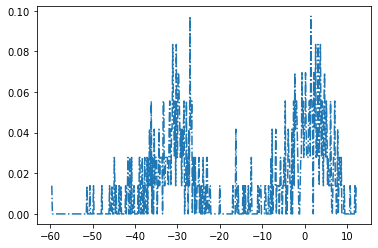

In [ ]:
from matplotlib import pyplot as plt
# plt.plot(x[i,:])
potencia = x[i,:]**2/2
potencia_log = 10*np.log10(potencia)

counts,edges=np.histogram(potencia_log,len(x[i,:]),density=True)
plt.plot(edges[:-1],counts,'-.')


In [3]:
# A       =   0.05   # Parametro A del Ruido Clase A
r       =   0.001  # Parametro gamma del Ruido de Clase A
M       =  10      # Cantidad de terminos a ser considerados en la sumatoria de la pdf de Ruido de Clase A
N       = 512      # Cantidad de muestras a ser generadas
Sigmag2 =   0.001  # Potencia de Ruido Gaussiano o Background Noise

surr = 20

A_min  = 18/N
A_max  = 530/N
A_step = 16/N
A_vec = np.arange(A_min,A_max,A_step)


y=np.empty((len(A_vec)*surr,3))
x=np.empty((len(A_vec)*surr,N))

for i,A in enumerate(A_vec):
    for j in range(0,surr):
        _, x[i*surr+j,:] = RFI_MakeEnvelopeDataClassA(A,r,M,N,Sigmag2)
        y[i*surr+j,0] = A
        y[i*surr+j,1] = r
        y[i*surr+j,2] = Sigmag2

In [4]:
np.save('./x_test1',x)
np.save('./y_test1',y)